# GluonTS - Quick Start Tutorial

- GluonTS is based on MXNet and a library for deep learning with time series
- GluonTS toolkit - Components and tools for building time series models using MXNet


In [1]:
### Third-party imports

# vis
%matplotlib inline
import matplotlib.pyplot as plt

# standards
import numpy as np
import pandas as pd

# mxnet
import mxnet as mx
from mxnet import gluon

# json
import json


## Datasets


### GluonTS datasets

#### `gluonts.dataset.repository.datasets.get_dataset`

- Get a repository dataset

Parameters: 

- **dataset_name** - name of the dataset, for instance "m4_hourly"
- **regenerate** - whether to regenerate the data even if a local file is present. If this flag is False and the file is present, the dataset will not be downloaded again. 
- **path** - where the dataset should be saved

Returns a dataset by either downloading or reloading from local file. 




In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [9]:
print("Available datasets:\n")
print(list(dataset_recipes.keys()))

Available datasets:

['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly']


**To do**

- Download `m4_hourly` using the `get_dataset` method


In [10]:
dataset = get_dataset("m4_hourly", regenerate=True)

INFO:root:downloading and processing m4_hourly


saving time-series into C:\Users\TM\.mxnet\gluon-ts\datasets\m4_hourly\train\data.json
saving time-series into C:\Users\TM\.mxnet\gluon-ts\datasets\m4_hourly\test\data.json


Datasets provided by GluonTS are objects that consists of three main members: 

- `dataset.train` - is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test`- is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length. 
- `dataset.metadata` - contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc. 



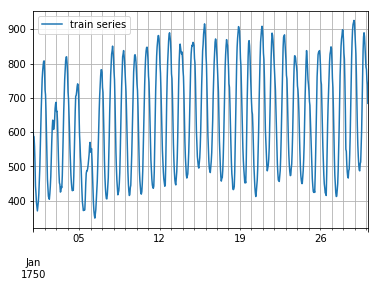

In [11]:
# datasets can be entered using list
# list(dataset.train)

# get one entry
entry = next(iter(dataset.train))

train_series = to_pandas(entry)
train_series.plot()

# add grid and legend
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()


In [14]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.head()

1750-01-01 00:00:00    605.0
1750-01-01 01:00:00    586.0
1750-01-01 02:00:00    586.0
1750-01-01 03:00:00    559.0
1750-01-01 04:00:00    511.0
Freq: H, dtype: float32

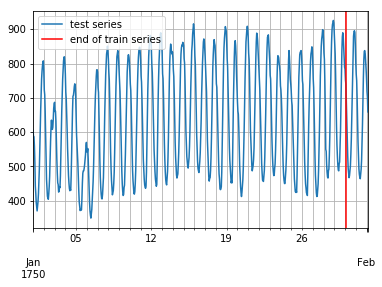

In [16]:
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [20]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## Custom datasets

Requirements for a custom dataset:

- data are to be iterable
- have a `target`, and a `start` field. 

**To do**

Assume a dataset in the form of a `nunmpy.array` is given and the index of the time series in a `pandas.Timestamp` (possibly different for each series 

- Split the dataset and bring it in a GluonTS appropriate format using `gluonts.dataset.common.ListDataset`

In [29]:
N = 10 # number of time series
T = 100 # number of timesteps

prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq)

print("Shape of dataset:",custom_dataset.shape)
print("Start:", start)

Shape of dataset: (10, 100)
Start: 2019-01-01 00:00:00


#### ListDataset

Dataset backed directly by an array of dictionaries

Parameters: 

- **data_iter**  - Iterable object yielding all items in the dataset. Each item should be a dictionary mapping strings to values. For instance `{"start": "2014-09-07", "target":[0.1, 0.2]}`  
- **freq** - Frequency of the observation in the time series. Must be a valid Pandas frequency. 
- **one_dim_target** - Whether to accept only univariate target time series. 



In [42]:
from gluonts.dataset.common import ListDataset

# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': x, 'start': start} 
                        for x in custom_dataset[:, :-prediction_length]],
                       freq=freq)


# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': x, 'start': start} 
                       for x in custom_dataset],
                      freq=freq)


## Training an existing model (`Estimator`)

- Built-in models can be used by configuring some hyperparameters
- Probabilistic models - Predictions in the form of a probability distribution, rather than a single point estimate.

Next: Using GluonTS's pre-build feedforward neural network estimator, a simple feed forward neural network ([`SimpleFeedForwardEstimator`](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.simple_feedforward.html))


#### SimpleFeedForwardEstimator 

- [`SimpleFeedForwardEstimator`](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.simple_feedforward.html)

Simple MLP model predicting the next target time-steps given the previous ones. 

Parameters: 

- **freq** - Time frequency of the data
- **prediction_length** - Length of the prediction horizon
- **trainer** - Trainer object ot be used (default: Trainer())
- **num_hidden_dimensions** - 
- **context_length** - Number of time units that condition the predictions (default: None, in which case context_length = prediction_length)
- ...

Accepts an input window (`context_length`) and predicts the distribution of the values of the subsequent `prediction_length` values. The feedforward neural network is an example of `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

Each estimator is configured by a number of hyperparameters and by a `Trainer`

What is the `Trainer`?

- The `Trainer` defines how the model will be trained i.e., the number of epochs, the learning rate, etc. 

**To do:**

- Import `SimpleFeedForwardEstimator` and the `Trainer`
- Instantiate an estimator object and specify
 - hyperparameters
 - trainer
 

In [45]:
# imports 
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions = [10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts. 

**To do:** 

- Train the estimator

In [47]:
%%time
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 483
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 88.87it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[0] Elapsed time 1.130 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.332442
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 75.69it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[1] Elapsed time 1.327 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.875419
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 92.14it/s, avg_epoch_loss=4.62]
INFO:root:Epoch[2] Elapsed time 1.090 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.622143
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 92.48it/s, avg_epoch_loss=4.65]
INFO:root:Epoch[3] Elapsed time 1.086 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.645933
INFO:root:Epoch[4] Learni

Wall time: 5.84 s


The `predictor` can now be used to predict the last window of the `dataset.test` and evaluate the model's performance. 

#### `make_evaluation_predictions`

The [`make_evaluation_predictions`](https://gluon-ts.mxnet.io/api/gluonts/gluonts.evaluation.backtest.html#gluonts.evaluation.backtest.make_evaluation_predictions) function automates the process of prediction and model evaluation. It

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects). 

Parameters: 

- **dataset** - Dataset where the evaluation will happen. Only the portion excluding the prediction_length portion is used when making prediction. 
- **predictor** - Model used to draw predictions
- **num_eval_samples** - Number of samples to draw on the model when evaluating. 

**To do:**

- Use `make_evaluation_predictions` to get forecasts 



In [62]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor,
    num_eval_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

In [71]:
# first entry of the time series list
ts_entry = tss[0]

# first 5 values
np.array(ts_entry[:10]).reshape(-1,)


array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370.],
      dtype=float32)

In [76]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

# first 5 values
dataset_test_entry["target"][:10]

array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370.],
      dtype=float32)

Entries in the `forecast` list are bit more complex. They are: 

- objects that contain all sample paths 
- `numpy.ndarray` with dimension `(num_samples, prediction_length)`
- start date of the forecast
- frequency of the time series

**To do:**

Extract the following forecast quantities: 

- `num_samples`
- `samples.shape`
- `start_date`
- `freq`



In [86]:
# first entry of forecast list
forecast_entry = forecasts[0]

print("Number of sample paths:", forecast_entry.num_samples)
print("Dimension of samples:", forecast_entry.samples.shape)
print("Start date of the forecast window:", forecast_entry.start_date)
print("Frequency of the time series:", forecast_entry.freq)


Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


**To do:**

Summarize the sample paths: 

- mean
- median


In [94]:
print("Mean of the future window:\n", forecast_entry.mean)
print("\nMedian of the future window:\n", forecast_entry.quantile(0.5))

Mean of the future window:
 [653.1443  573.91736 533.97784 509.44568 484.4106  468.31683 533.378
 475.85907 464.47015 544.6993  606.4829  714.47675 746.18195 751.1417
 834.4523  859.5214  870.2642  927.65515 863.92413 871.28143 863.3606
 796.16406 813.42615 746.34985 651.2888  640.52563 577.9303  559.7723
 527.83673 431.6789  447.59512 535.7609  521.98615 565.0057  610.0244
 656.5546  721.33514 755.9607  816.09186 909.63947 827.5694  894.5817
 904.27185 873.7869  861.9483  785.27966 776.41974 691.62775]

Median of the future window:
 [649.5749  571.58417 536.21075 515.4848  480.99332 470.51706 533.40564
 480.98816 477.32993 546.05597 603.6725  709.8321  723.5399  742.8353
 852.64777 863.0462  862.2444  915.3072  867.1982  887.25543 808.58203
 809.7081  810.0047  739.73975 660.31665 635.6171  576.356   556.59174
 528.6974  432.92578 453.48752 513.6783  499.32883 576.3363  606.68304
 658.3172  737.34863 767.9266  795.62146 899.2284  842.694   914.02454
 885.99243 851.38403 854.70087 779.

#### Visualization

`Forecast` objcts have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. 

The prediction intervals are shaded in different colors as a "fan chart". 

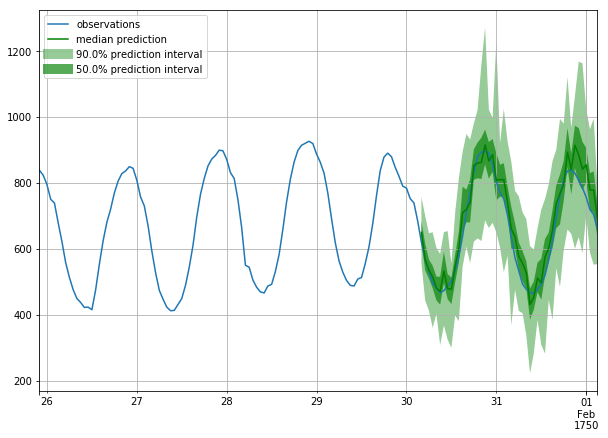

In [96]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
    
plot_prob_forecasts(ts_entry, forecast_entry)

#### Numerical evaluation with `Evaluator` class 

Next, evaluate the quality of the forecasts numerically using the `Evaluator` class. 

The `Evaluator` class is used to compute accuracy metrics by comparing observations to forecasts. 

Parameters: 

- **quantiles** - list of strings of the form `p10` or floats in `[0,1]` with the quantile levels
- **seasonality** - seasonality to use for seasonal_error, if nothing is passed uses the default seasonality for the given seies frequency as returned by get_seasonality. 
- **alpha** - parameter of the MSIS metric from M4 competition that defines the confidence interval for alpha=0.05, the 95% considered in the metric, see https://www.m4.unic.ac.cy/wp-content/uploads/2018/03/M4 for more details on MSIS.

In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can useful for analyzing performance across heterogeneous time series). 



In [97]:
%%time

from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), 
                                      iter(forecasts),
                                      num_series=len(dataset.test))


Running evaluation: 100%|██████████| 414/414 [00:05<00:00, 78.77it/s]


#### `json`

- JSON encoder and decoder
- Use `json.dumps()`to convert
- If indent is a non-negative integer or string, then JSON array elements and object members will be pretty-printed with that indent level.

In [103]:
# use json.dumps()
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 9873796.76096929,
    "abs_error": 9793349.506690979,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 3.2563355552574285,
    "sMAPE": 0.188021904663731,
    "MSIS": 35.32199141163232,
    "QuantileLoss[0.1]": 4237256.410919953,
    "Coverage[0.1]": 0.1210245571658615,
    "QuantileLoss[0.5]": 9793349.504416943,
    "Coverage[0.5]": 0.5794585346215781,
    "QuantileLoss[0.9]": 7046292.189381121,
    "Coverage[0.9]": 0.8803341384863119,
    "RMSE": 3142.2598175468065,
    "NRMSE": 0.42898787164245006,
    "ND": 0.06728102476555238,
    "wQuantileLoss[0.1]": 0.029110260317608886,
    "wQuantileLoss[0.5]": 0.06728102474992959,
    "wQuantileLoss[0.9]": 0.0484085408138624,
    "mean_wQuantileLoss": 0.04826660862713362,
    "MAE_Coverage": 0.040049651100375915
}


In [105]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,2149.963053,1698.144531,31644.0,659.250000,42.371302,0.834952,0.052872,5.466720,842.647931,0.000000,1698.144501,0.791667,1381.019507,1.000000
1,NaN,168183.947917,18837.052734,124149.0,2586.437500,165.107988,2.376860,0.145608,14.506076,4449.368750,0.250000,18837.052124,1.000000,8386.790527,1.000000
2,NaN,24895.255208,5613.278809,65030.0,1354.791667,78.889053,1.482377,0.081788,10.169155,3119.651648,0.000000,5613.278748,0.270833,2065.867163,0.812500
3,NaN,200970.083333,15606.785156,235783.0,4912.145833,258.982249,1.255458,0.064720,8.267640,9506.841943,0.020833,15606.784912,0.500000,7802.562012,0.979167
4,NaN,100508.395833,11439.931641,131088.0,2731.000000,200.494083,1.188723,0.078401,6.953554,4276.767578,0.083333,11439.931885,0.812500,7368.744775,1.000000


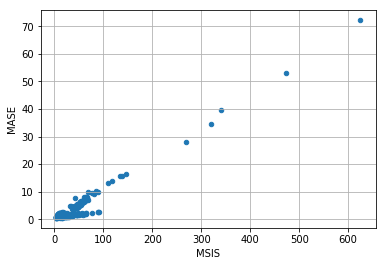

In [107]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

### Create your own forecast model

- Continue here: https://github.com/awslabs/gluon-ts/blob/master/docs/examples/basic_forecasting_tutorial/tutorial.md#create-your-own-forecast-model